In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import json
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import statistics

/home/clarice/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
markers = ['o', '*', 'v', '^', '<', 's']
sns.set_palette(palette=['#AC2C0C', '#3A7E5E', '#495867','#577399','#BDD5EA','#B5CA8D'])
plt.rcParams.update({"text.usetex": True, "font.family" : "serif", "font.serif" : ["Computer Modern Serif"]})

In [3]:
# Function to calculate the total demand
def calculate_total_demand(data):
    total_demand = 0
    scenarios = data['scenarios']
    for scenario in scenarios:
        for area_data in scenario['data']:
            total_demand += sum(area_data['demand'])
    return total_demand/data['num_scenarios']

In [5]:
# Load in files
directory = '../../raw_results'
file_names = os.listdir(directory)
#file_names = [name for name in file_names if 'paris' in name or 'lyon' in name]
file_names = [name for name in file_names if 'paris' in name or 'frankfurt' in name or 'lyon' in name]
list_concat = []
results_df = pd.DataFrame()

for i in range(len(file_names)):
    results_file = f'{directory}/{file_names[i]}'
    with open(results_file, 'rb') as file:
        sol = pickle.load(file)
    #print(file_names[i])

    # Calculate number of total packages
    pattern = r'^(.+?)_OC'
    base_name = re.search(pattern, file_names[i]).group(1)
    weekday_path = f'../../instances/{base_name}_dt=doublepeak.json'
    weekend_path = f'../../instances/{base_name}_dt=uniform.json'
 

    with open(weekday_path, 'r') as file:
        weekday = json.load(file)

    with open(weekend_path, 'r') as file:
        weekend = json.load(file)

    weekend_demand = calculate_total_demand(weekend)
    weekday_demand = calculate_total_demand(weekday)
    total_demand = weekend_demand*2 + weekday_demand*5


    # Obtain baseline results
    keys_to_keep = ['city', 'demand_baseline', 'outsourcing_cost_multiplier', 'model', 'max_n_shifts', 'workforce_size', 'wage_costs', 'objective_value', 'objective_value_post_wage']
    filtered_baseline = {key: sol['baseline'][key] for key in keys_to_keep}
    results_temp = pd.DataFrame(filtered_baseline)

    # duplicate row to store roster results
    results_temp = pd.concat([results_temp, results_temp], axis=0, ignore_index=True)
    results_temp.at[0, 'model'] =  'baseline'

    # Deal with region key inconsistency
    if 'region' in sol.keys():
        regions = sol['region']
    else:
        regions =  sol['regions']



    # Add the roster results
    wage_costs = sum( (employee, shift_start, day) in sol['r']
                    for region in regions 
                    for employee in sol['employees'][region]
                    for day in sol['days']
                    for shift_start in sol['shifts'][(region, day)])*4

    results_temp.at[1, 'objective_value'] = sol['obj_val']
    results_temp.at[1, 'wage_costs'] = wage_costs

    results_temp['total_packages'] = total_demand
    results_temp['cost_per_package'] = results_temp['objective_value']/total_demand
    results_temp['wage_cost_per_package'] = results_temp['wage_costs']/total_demand
    results_temp['outsourcing_cost_per_package'] = results_temp['cost_per_package'] - results_temp['wage_cost_per_package']

    # Calculate percentage of outsourced parcels
    ############################################
    # Obtain the list of areas
    area_list = []
    for region in sol['regions']:
        for area in sol['reg_areas'][region]:
            area_list.append(area)

    # Calculate the understaffed percentage
    understaffed_pct_roster = {}
    understaffed_pct_baseline = {}
    overstaffed_pct_baseline = {}
    overstaffed_pct_roster = {}
    for area in area_list:
        for day in range(7):
            for theta in range(8):
                hired_couriers_roster = sum((employee, a, period, d) in sol['k'] for employee, a, period, d in sol['k'] if period == theta and d == day and a == area)
                hired_couriers_baseline = sum((employee, a, period, d) in sol['baseline']['k'] for employee, a, period, d in sol['baseline']['k'] if period == theta and d == day and a == area)

                if day < 5:
                    required_couriers  = sum(area_data['required_couriers'][theta] for scenario in weekday['scenarios'] for area_data in scenario['data'] if area_data['area_id'] == area)/weekday['num_scenarios']
                else:
                    required_couriers = sum(area_data['required_couriers'][theta] for scenario in weekend['scenarios'] for area_data in scenario['data'] if area_data['area_id'] == area)/weekend['num_scenarios']

                if required_couriers != 0:
                    understaffed_pct_roster[area, day, theta] = max(0, (required_couriers - hired_couriers_roster)/required_couriers)*100
                    understaffed_pct_baseline[area, day, theta] = max(0, (required_couriers - hired_couriers_baseline)/required_couriers)*100
                else:
                    understaffed_pct_roster[area, day, theta] = 0
                    understaffed_pct_baseline[area, day, theta] = 0

                if hired_couriers_baseline != 0:
                    overstaffed_pct_baseline[area, day, theta] =  max(0, (hired_couriers_baseline - required_couriers)/hired_couriers_baseline)*100
                else:
                    overstaffed_pct_baseline[area, day, theta] = 0

                if hired_couriers_roster != 0:
                    overstaffed_pct_roster[area, day, theta] = max(0, (hired_couriers_roster - required_couriers)/hired_couriers_roster)*100
                else:
                    overstaffed_pct_roster[area, day, theta] = 0
        
    results_temp.at[0, 'outsourced_pct'] = statistics.mean(understaffed_pct_baseline.values())
    results_temp.at[1, 'outsourced_pct'] = statistics.mean(understaffed_pct_roster.values())

    results_temp.at[0, 'idle_pct'] = statistics.mean(overstaffed_pct_baseline.values())
    results_temp.at[1, 'idle_pct'] = statistics.mean(overstaffed_pct_roster.values())


    list_concat.append(results_temp)


results_df = pd.concat(list_concat, axis=0, ignore_index=True)

# replace non an na values with 0
results_df = results_df.fillna(0)

# Fix model names
results_df['model'] = np.where(
    (results_df['max_n_shifts']!=0) & (results_df['model'] != "baseline"),  # Condition to check non-null values
    results_df['model'] + '-' + results_df['max_n_shifts'].astype(str),  # True condition
    results_df['model']  # False condition, keep the original 'model'
)

results_df['model'] = results_df['model'].replace({
    'partflex-2': 'partflex-2.0',
    'partflex-3': 'partflex-3.0',
    'partflex-4': 'partflex-4.0'
})


KeyboardInterrupt: 

# Cost Graphs

In [118]:
models_textsc = {
    'baseline': '\\textsc{MBase}',
    'flex': '\\textsc{Flex}',
    'partflex-4.0': '\\textsc{PartFlex} ($\\mu = 4$)',
    'partflex-3.0': '\\textsc{PartFlex} ($\\mu = 3$)',
    'partflex-2.0': '\\textsc{PartFlex} ($\\mu = 2$)',
    'fixed': '\\textsc{Fixed}'
}

In [119]:
def add_fig_legend(fig, bbox_to_anchor=(.5,-0.095)):
    elements = [
        (
            Patch(facecolor='C0', edgecolor='C0'),
            Line2D([0], [0], color='C0', marker=markers[0], markersize=8)
        ),
        (
            Patch(facecolor='C1', edgecolor='C1'),
            Line2D([0], [0], color='C1', marker=markers[1], markersize=8)
        ),
        (
            Patch(facecolor='C2', edgecolor='C2'),
            Line2D([0], [0], color='C2', marker=markers[2], markersize=8)
        ),
        (
            Patch(facecolor='C3', edgecolor='C3'),
            Line2D([0], [0], color='C3', marker=markers[3], markersize=8)
        ),
        (
            Patch(facecolor='C4', edgecolor='C4'),
            Line2D([0], [0], color='C4', marker=markers[4], markersize=8)
        ),
        (
            Patch(facecolor='C5', edgecolor='C5'),
            Line2D([0], [0], color='C5', marker=markers[5], markersize=8)
        ),
        Patch(facecolor='white', edgecolor='black'),
        Patch(facecolor='white', edgecolor='black', hatch='\\\\')
    ]
    
    fig.legend(
        handles=elements, handler_map={tuple: HandlerTuple(ndivide=2)},
        labels=[
            '\\textsc{MBase}', '\\textsc{Flex}', '\\textsc{PartFlex} ($\\mu = 4$)', '\\textsc{PartFlex} ($\\mu = 3$)', '\\textsc{PartFlex} ($\\mu = 2$)',
            '\\textsc{Fixed}', 'Outsourcing Costs', 'Hiring costs'
        ],
        fontsize=14, loc='lower center', bbox_to_anchor=bbox_to_anchor,
        ncols=4, handlelength=5, frameon=False
    )

    return fig

In [120]:
def add_fig_legend_no_base(fig, bbox_to_anchor=(.5,-0.095)):
    elements = [
        (
            Patch(facecolor='C1', edgecolor='C1'),
            Line2D([0], [0], color='C1', marker=markers[1], markersize=8)
        ),
        (
            Patch(facecolor='C2', edgecolor='C2'),
            Line2D([0], [0], color='C2', marker=markers[2], markersize=8)
        ),
        (
            Patch(facecolor='C3', edgecolor='C3'),
            Line2D([0], [0], color='C3', marker=markers[3], markersize=8)
        ),
        (
            Patch(facecolor='C4', edgecolor='C4'),
            Line2D([0], [0], color='C4', marker=markers[4], markersize=8)
        ),
        (
            Patch(facecolor='C5', edgecolor='C5'),
            Line2D([0], [0], color='C5', marker=markers[5], markersize=8)
        ),
        Patch(facecolor='white', edgecolor='black'),
        Patch(facecolor='white', edgecolor='black', hatch='\\\\')
    ]
    
    fig.legend(
        handles=elements, handler_map={tuple: HandlerTuple(ndivide=2)},
        labels=[
            '\\textsc{Flex}', '\\textsc{PartFlex} ($\\mu = 4$)', '\\textsc{PartFlex} ($\\mu = 3$)', '\\textsc{PartFlex} ($\\mu = 2$)',
            '\\textsc{Fixed}', 'Outsourcing Costs', 'Hiring costs'
        ],
        fontsize=14, loc='lower center', bbox_to_anchor=bbox_to_anchor,
        ncols=4, handlelength=5, frameon=False
    )

    return fig

## Cost overview

In [132]:
def plot_cost_overview():
    plt.rcParams['hatch.linewidth'] = 2

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6))

    ax = axes.flat[0]
    
    models = ['baseline', 'flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

    # Boxplot
    sns.boxplot(data=results_df, x='model', y='cost_per_package', order=models, hue='model', hue_order=models, fliersize=0, ax=ax, palette=sns.color_palette())
    ax.set_ylim((0, 0.8))
    ax.set_ylabel('Avg cost per parcel', fontsize=16)
    ax.set_xlabel('')

    for idx, model in enumerate(models):
        avg = results_df[results_df['model'] == model]['cost_per_package'].median()
        ax.text(x=idx, y=avg, s=f"{avg:.2f}", va='bottom', ha='center', color='white', fontsize=16, fontweight='bold')

    ax.annotate(text = '\\textsc{Roster}', xy=(0.58, -0.45), xytext=(0.58, -0.55), xycoords='axes fraction', 
            fontsize=16, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=0.1', lw=1.0, color='k'))
    
    ax = axes.flat[1]

    # Barplot
    ticks = range(len(models))
    outsourcing_costs = results_df.groupby('model', observed=True)['outsourcing_cost_per_package'].mean().reindex(models)
    wage_costs = results_df.groupby('model', observed=True)['wage_cost_per_package'].mean().reindex(models)
    
    ax.bar(
        x=ticks,
        height=outsourcing_costs,
        color=[f"C{i}" for i in ticks],
        linewidth=2,
        edgecolor='white'
    )

    first_patches = ax.patches[:]
    ax.bar(
        x=ticks,
        height=wage_costs,
        bottom=outsourcing_costs,
        color=[f"C{i}" for i in ticks],
        linewidth=2,
        edgecolor='white'
    )

    for bar in ax.patches:
        if bar in first_patches:
            continue
        bar.set_hatch('\\')

    ax.set_ylim((0, 0.8))
    ax.set_xticks(ticks)
    ax.set_xticklabels(models)
    ax.yaxis.tick_right()
    ax.set_ylabel('Avg cost per parcel', rotation=270, labelpad=20, fontsize=16)
    ax.yaxis.set_label_position('right')
    ax.yaxis.grid(which='major')
    ax.axes.set_axisbelow(True)
    ax.set_xlabel('')

    ax.legend(handles=[
        Patch(facecolor='white', edgecolor='black', label='Outsourcing costs'),
        Patch(facecolor='white', edgecolor='black', hatch='\\\\', label='Hiring costs')
    ], loc='upper center', ncols=2, frameon=False, fontsize=16)

    # Add "Roster" label and encompassing line
    plt.subplots_adjust(bottom=0.3)  # Increase as needed

    ax.annotate(text = '\\textsc{Roster}', xy=(0.58, -0.45), xytext=(0.58, -0.55), xycoords='axes fraction', 
            fontsize=16, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=8.9, lengthB=0.1', lw=1.0, color='k'))
   
    
    for ax in axes.flat:
        ticklabels = [lbl.get_text() for lbl in ax.get_xticklabels()]
        ticklabels = [models_textsc[lbl] for lbl in ticklabels]
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ticklabels, fontsize=16)

        for tl in ax.get_xticklabels():
            tl.set_rotation_mode('anchor')
            tl.set_rotation(45)
            tl.set_ha('right')
        for tl in ax.get_yticklabels():
            tl.set_fontsize(14)

    fig.tight_layout()
    fig.savefig('figures/cost_overview.pdf', dpi=96, bbox_inches='tight')

    return fig, axes


(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: ylabel='Avg cost per parcel'>,
        <Axes: ylabel='Avg cost per parcel'>], dtype=object))

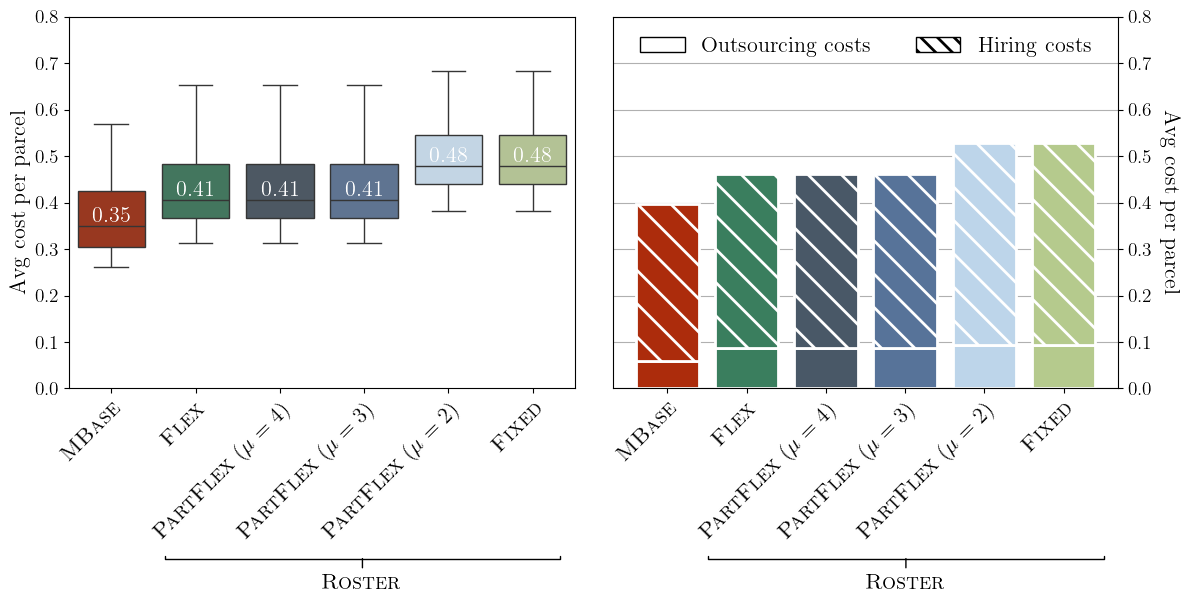

In [133]:
plot_cost_overview()

## Cost increase breakdown

In [124]:
def plot_cost_increase():

    plt.rcParams['hatch.linewidth'] = 1

    oc_values = [1.2, 1.5, 1.8, 2.0, 2.5]
    models = ['baseline', 'flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6))

    ax = axes.flat[0]

    sns.lineplot(
        data=results_df, x='outsourcing_cost_multiplier', y='idle_pct',
        hue='model',  
        hue_order=models,
        style='model',
        errorbar=None, markers=markers, dashes=False, ax=ax , palette=sns.color_palette())
    ax.legend().set_visible(False)
    ax.axes.set_axisbelow(True)
    ax.axes.set_xticks(oc_values)
    ax.set_xlabel('\\texttt{OC}', fontsize=16)
    ax.set_ylabel('Idle couriers (\\%)', fontsize=16)

    ax = axes.flat[1]
    models = ['flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

    # Bar plot
    n_models = 5
    n_oc = len(oc_values)

    ticks = [oc_idx * (n_models + 1) + (n_models / 2) + 1 for oc_idx in range(n_oc)]

    for oc_idx, oc_val in enumerate(oc_values):
        for model_idx, model_long in enumerate(models):
            bar_x = oc_idx * (n_models + 1) + model_idx + 1
            data_base = results_df[(results_df['outsourcing_cost_multiplier'] == oc_val) & (results_df['model'] == "baseline")]
            data = results_df[(results_df['outsourcing_cost_multiplier'] == oc_val) & (results_df['model'] == model_long)]
            hc = data['wage_cost_per_package'].mean() - data_base['wage_cost_per_package'].mean()
            oc = data['outsourcing_cost_per_package'].mean() - data_base['outsourcing_cost_per_package'].mean() 

            ax.bar(x=[bar_x], height=[oc], color=f"C{model_idx+1}", linewidth=1, edgecolor='white')
            ax.bar(x=[bar_x], height=[hc], bottom=[oc], color=f"C{model_idx+1}", linewidth=1, edgecolor='white', hatch='\\')


    ax.set_xticks(ticks)
    ax.set_xticklabels(oc_values)
    ax.set_xlabel('\\texttt{OC}', fontsize=16)
    ax.yaxis.tick_right()
    ax.set_ylabel('Avg increase in cost per parcel', rotation=270, labelpad=20, fontsize=16)
    ax.yaxis.set_label_position('right')
    ax.yaxis.grid(which='major')
    ax.set_axisbelow(True)
    ax.tick_params(which='major', axis='x', length=0)

    for ax in axes.flat:
        for tl in ax.get_xticklabels():
            tl.set_fontsize(14)
        for tl in ax.get_yticklabels():
            tl.set_fontsize(14)
    
    add_fig_legend(fig, bbox_to_anchor=(0.5, -0.15))


    fig.tight_layout()
    fig.savefig('figures/cost_increase.pdf', dpi=96, bbox_inches='tight')

    return fig, ax


(<Figure size 1200x600 with 2 Axes>,
 <Axes: xlabel='\\texttt{OC}', ylabel='Avg increase in cost per parcel'>)

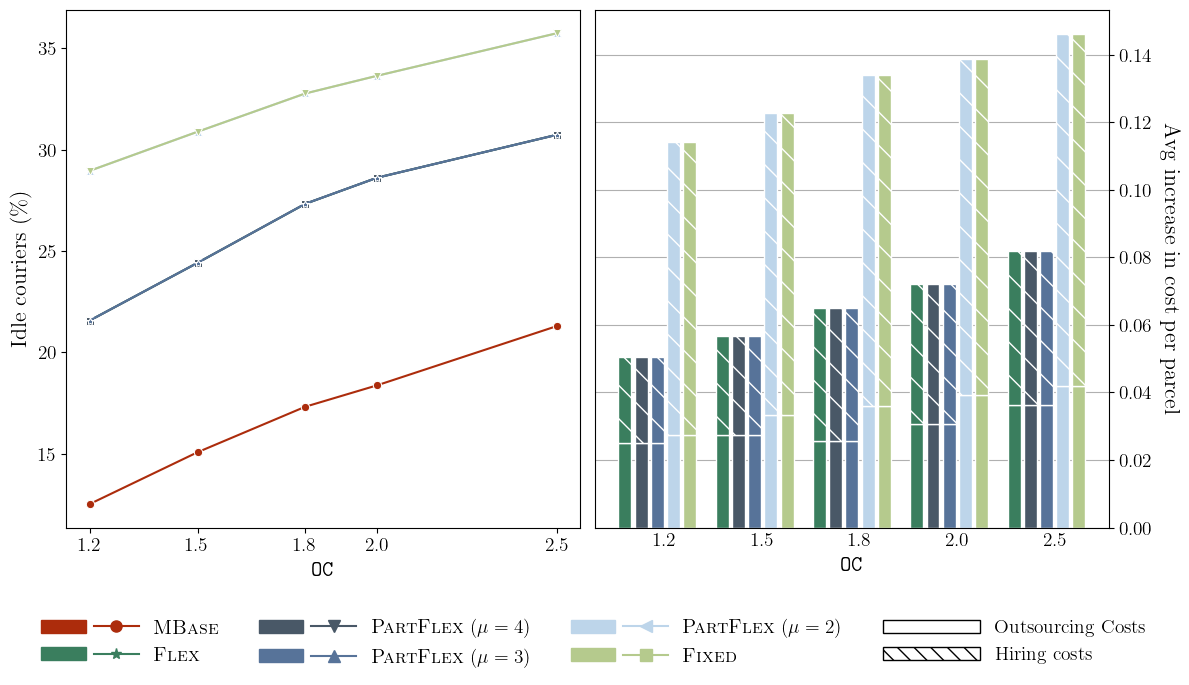

In [125]:
plot_cost_increase()

## Impact of the demand baseline

In [126]:
def plot_db_impact():
    plt.rcParams['hatch.linewidth'] = 1

    db_values = [0.5, 1.0, 2.0, 4.0]
    models = ['baseline', 'flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']



    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6))

    ax = axes.flat[0]

    sns.lineplot(
        data=results_df, x='demand_baseline', y='outsourced_pct',
        hue='model',  
        hue_order=models,
        style='model',
        errorbar=None, markers=markers, dashes=False, ax=ax , palette=sns.color_palette())
    ax.legend().set_visible(False)
    ax.axes.set_axisbelow(True)
    ax.axes.set_xticks(db_values)
    ax.set_xlabel('\\texttt{DB}', fontsize=16)
    ax.set_ylabel('Parcels outsourced (\\%)', fontsize=16)

    for db in db_values:
        ax.axvline(x=db, linestyle='--', color='black', linewidth=0.5, alpha=0.25)

    ax = axes.flat[1]

    n_models = 6
    n_db = len(db_values)

    ticks = [(x1 + x2) / 2 for x1, x2 in zip(range(1, n_db* n_models, n_models + 1), range(n_models, n_db * (n_models + 1), n_models + 1))]

    for db_idx, db in enumerate(db_values):
        for model_idx, model_long in enumerate(models):
            bar_x = db_idx * (n_models + 1) + model_idx + 1
            data = results_df[(results_df['demand_baseline'] == db) & (results_df['model'] == model_long)]
            hc = data['wage_cost_per_package'].mean()
            oc = data['outsourcing_cost_per_package'].mean()

            ax.bar(x=[bar_x], height=[oc], color=f"C{model_idx}", linewidth=1, edgecolor='white')
            ax.bar(x=[bar_x], height=[hc], bottom=[oc], color=f"C{model_idx}", linewidth=1, edgecolor='white', hatch='\\')


    ax.set_xticks(ticks)
    ax.set_xticklabels(db_values)
    ax.set_xlabel('\\texttt{DB}', fontsize=16)
    ax.yaxis.tick_right()
    ax.set_ylabel('Avg cost per parcel', rotation=270, labelpad=20, fontsize=16)
    ax.yaxis.set_label_position('right')
    ax.yaxis.grid(which='major')
    ax.set_axisbelow(True)
    ax.tick_params(which='major', axis='x', length=0)

    for ax in axes.flat:
        for tl in ax.get_xticklabels():
            tl.set_fontsize(14)
        for tl in ax.get_yticklabels():
            tl.set_fontsize(14)

    add_fig_legend(fig, bbox_to_anchor=(0.5, -0.15))

    fig.tight_layout()
    fig.savefig('figures/db.pdf', dpi=96, bbox_inches='tight')

    return fig, axes

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: xlabel='\\texttt{DB}', ylabel='Parcels outsourced (\\%)'>,
        <Axes: xlabel='\\texttt{DB}', ylabel='Avg cost per parcel'>],
       dtype=object))

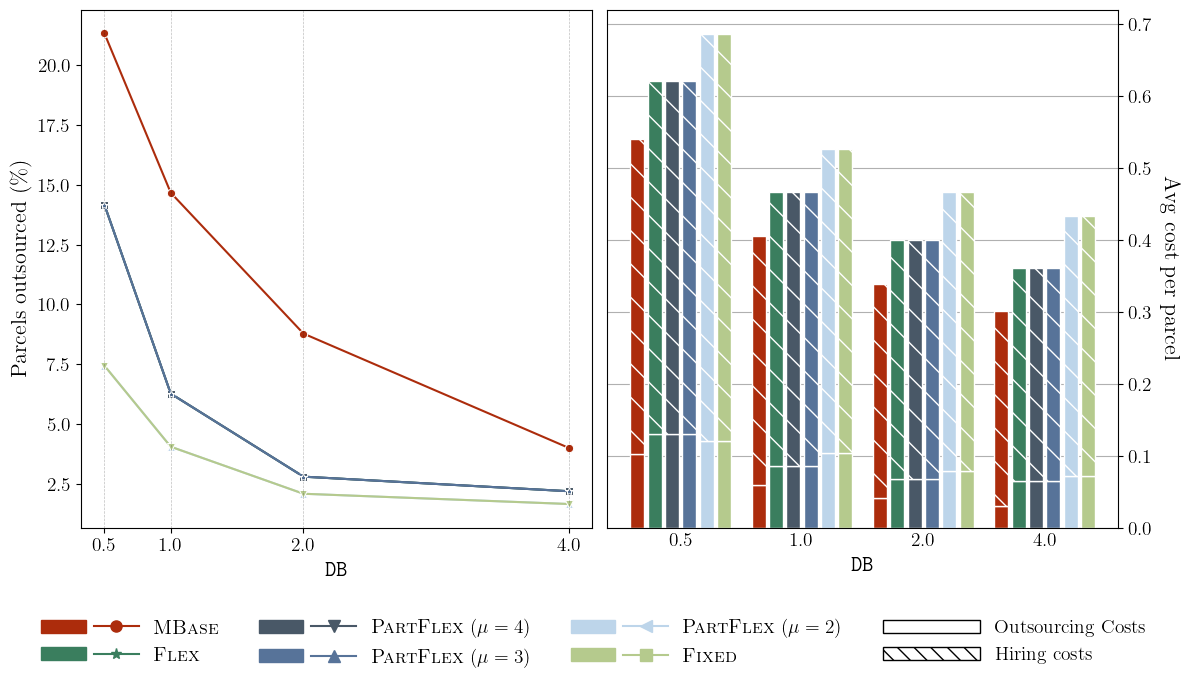

In [127]:
plot_db_impact()

In [128]:
results_df[(results_df['demand_baseline'] == 0.50)&\
    (results_df['outsourcing_cost_multiplier'] == 1.2)&\
        (results_df['model']!='baseline')]

,city,demand_baseline,outsourcing_cost_multiplier,model,max_n_shifts,workforce_size,wage_costs,objective_value,objective_value_post_wage,total_packages,cost_per_package,wage_cost_per_package,outsourcing_cost_per_package,outsourced_pct,idle_pct
11,lyon,0.5,1.2,partflex-3.0,3.0,46,1048.0,1391.126667,223.010000,2965.066667,0.469172,0.353449,0.115723,17.592440,15.641431
27,lyon,0.5,1.2,partflex-2.0,2.0,59,1216.0,1536.083333,218.583333,2965.066667,0.518060,0.410109,0.107951,4.029551,24.450025
85,paris,0.5,1.2,fixed,0.0,118,2628.0,3587.008000,375.458571,7705.200000,0.465531,0.341068,0.124462,7.848066,26.688478
117,lyon,0.5,1.2,partflex-4.0,4.0,46,1048.0,1391.126667,223.010000,2965.066667,0.469172,0.353449,0.115723,17.592440,15.641431
135,frankfurt,0.5,1.2,flex,0.0,60,1024.0,1422.580000,416.500000,1778.266667,0.799981,0.575842,0.224140,41.627730,13.692026
161,paris,0.5,1.2,flex,0.0,98,2256.0,3168.358946,571.716286,7705.200000,0.411197,0.292789,0.118408,15.313879,19.405825
327,paris,0.5,1.2,partflex-4.0,4.0,98,2256.0,3168.358946,571.716286,7705.200000,0.411197,0.292789,0.118408,15.313879,19.405825
407,paris,0.5,1.2,partflex-2.0,2.0,118,2628.0,3587.008000,375.458571,7705.200000,0.465531,0.341068,0.124462,7.848066,26.688478
409,paris,0.5,1.2,partflex-3.0,3.0,98,2256.0,3168.358946,571.716286,7705.200000,0.411197,0.292789,0.118408,15.313879,19.405825
517,frankfurt,0.5,1.2,partflex-2.0,2.0,70,1284.0,1583.900000,414.420000,1778.266667,0.890699,0.722051,0.168647,25.011710,25.518353


## By OC multiplier

In [129]:
def plot_oc_impact(region_index):
    plt.rcParams['hatch.linewidth'] = 1

    oc_values = [1.2, 1.5, 1.8, 2.0, 2.5]
    models = ['baseline', 'flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']


    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6))

    ax = axes.flat[0]

    # Add the roster results
    wage_costs = sum( (employee, shift_start, day) in sol['r']
                    for region in [region_index]
                    for employee in sol['employees'][region_index]
                    for day in sol['days']
                    for shift_start in sol['shifts'][(region_index, day)])*4

    results_temp.at[1, 'objective_value'] = sol['obj_val']
    results_temp.at[1, 'wage_costs'] = wage_costs

    results_temp['total_packages'] = total_demand
    results_temp['cost_per_package'] = results_temp['objective_value']/total_demand
    results_temp['wage_cost_per_package'] = results_temp['wage_costs']/total_demand
    results_temp['outsourcing_cost_per_package'] = results_temp['cost_per_package'] - results_temp['wage_cost_per_package']







    sns.lineplot(
        data=results_df, x='outsourcing_cost_multiplier', y='outsourced_pct',
        hue='model',  
        hue_order=models,
        style='model',
        errorbar=None, markers=markers, dashes=False, ax=ax , palette=sns.color_palette())
    ax.legend().set_visible(False)
    ax.axes.set_axisbelow(True)
    ax.axes.set_xticks(oc_values)
    ax.set_xlabel('\\texttt{OC}', fontsize=16)
    ax.set_ylabel('Parcels outsourced (\\%)', fontsize=16)

    for oc in oc_values:
        ax.axvline(x=oc, linestyle='--', color='black', linewidth=0.5, alpha=0.25)

    ax = axes.flat[1]

    n_models = 6
    n_oc = len(oc_values)

    ticks = [(x1 + x2) / 2 for x1, x2 in zip(range(1, n_oc* n_models, n_models + 1), range(n_models, n_oc * (n_models + 1), n_models + 1))]

    for oc_idx, oc_val in enumerate(oc_values):
        for model_idx, model_long in enumerate(models):
            bar_x = oc_idx * (n_models + 1) + model_idx + 1
            data = results_df[(results_df['outsourcing_cost_multiplier'] == oc_val) & (results_df['model'] == model_long)]
            hc = data['wage_cost_per_package'].mean()
            oc = data['outsourcing_cost_per_package'].mean()

            ax.bar(x=[bar_x], height=[oc], color=f"C{model_idx}", linewidth=1, edgecolor='white')
            ax.bar(x=[bar_x], height=[hc], bottom=[oc], color=f"C{model_idx}", linewidth=1, edgecolor='white', hatch='\\')


    ax.set_xticks(ticks)
    ax.set_xticklabels(oc_values)
    ax.set_xlabel('\\texttt{OC}', fontsize=16)
    ax.yaxis.tick_right()
    ax.set_ylabel('Avg cost per parcel', rotation=270, labelpad=20, fontsize=16)
    ax.yaxis.set_label_position('right')
    ax.yaxis.grid(which='major')
    ax.set_axisbelow(True)
    ax.tick_params(which='major', axis='x', length=0)

    for ax in axes.flat:
        for tl in ax.get_xticklabels():
            tl.set_fontsize(14)
        for tl in ax.get_yticklabels():
            tl.set_fontsize(14)

    add_fig_legend(fig, bbox_to_anchor=(0.5, -0.15))

    fig.tight_layout()
    fig.savefig('figures/oc.pdf', dpi=96, bbox_inches='tight')

    return fig, axes

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: xlabel='\\texttt{OC}', ylabel='Parcels outsourced (\\%)'>,
        <Axes: xlabel='\\texttt{OC}', ylabel='Avg cost per parcel'>],
       dtype=object))

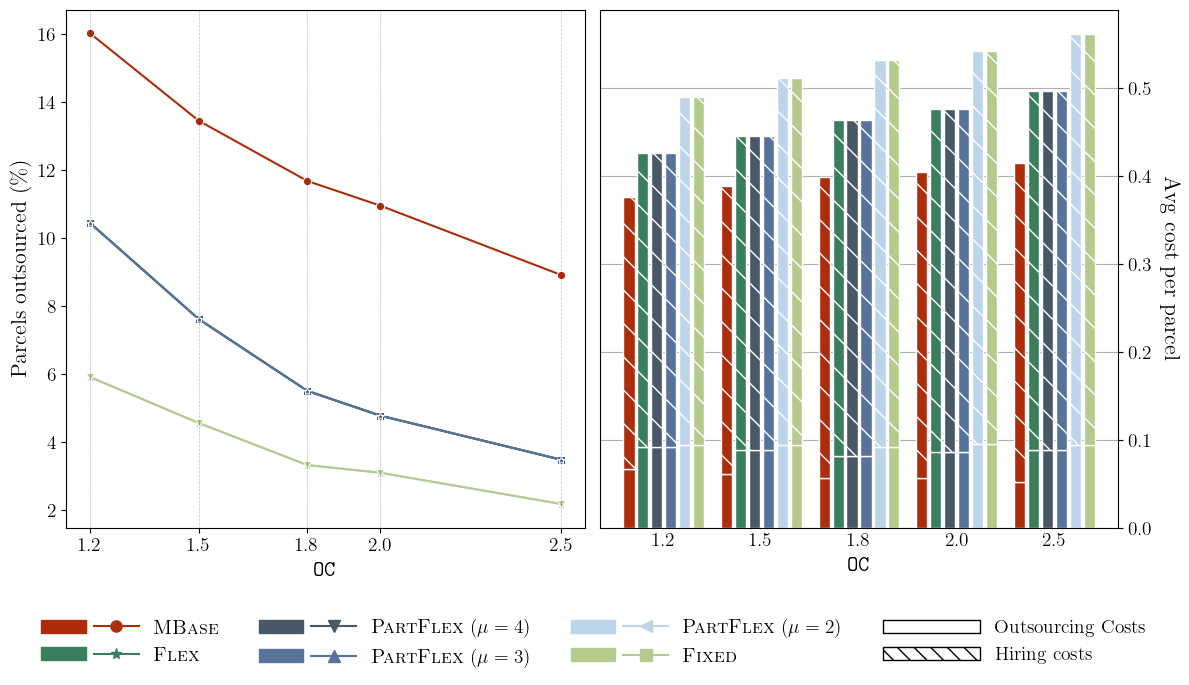

In [130]:
plot_oc_impact()

In [131]:
results_df.to_excel('test.xlsx', index=False)